Sveučilište u Zagrebu<br>
Fakultet elektrotehnike i računarstva

# Strojno učenje
<a href="http://www.fer.unizg.hr/predmet/su">http://www.fer.unizg.hr/predmet/su</a>

Ak. god. 2015./2016.

# Laboratorijska vježba 3: Logistička regresija i SVM

(c) 2015 Jan Šnajder

*Verzija 0.1*

Objavljeno: **8. prosinca 2015.**<br>
Rok za predaju: **14-18. prosinca 2015.**

Ante Žužul
0036473146

## Upute

Laboratorijska vježba 3 sastoji se od 12 zadataka. U nastavku slijedite upute navedene u ćelijama s tekstom. Rješavanje vježbe svodi se na **dopunjavanje ove bilježnice**: umetanja ćelije ili više njih **ispod** teksta zadatka, pisanja odgovarajućeg koda te evaluiranja ćelija. Odgovore na pitanja **nemojte pisati** u bilježnicu koju ćete demonstrirati asistentu (kako ih pri predaji ne bi samo čitali).

Osigurajte da u potpunosti **razumijete** kod koji ste napisali. Kod predaje vježbe, morate biti u stanju na zahtjev asistenta preinačiti i ponovno evaluirati Vaš kod. Nadalje, morate razumjeti teorijske osnove onoga što radite, u okvirima onoga što smo obradili na predavanju. Stoga se nemojte ograničiti samo na to da riješite zadatak, već slobodno eksperimentirajte. To upravo i jest svrha ovih vježbi.

Vježbe trebate raditi **samostalno**. Možete se konzultirati s drugima o načelnom načinu rješavanja, ali u konačnici morate sami odraditi vježbu. U protivnome vježba nema smisla.

In [1]:
# Učitaj osnovne biblioteke...
import scipy as sp
import sklearn as sk
import matplotlib.pyplot as plt
%pylab inline

Populating the interactive namespace from numpy and matplotlib


Pomoćna funkcija za iscrtavanje ulaznog prostora primjera i granice između klasa:

In [2]:
def plot_problem(X, y, h=None, surfaces=True) :
    '''
    Plots a two-dimensional labeled dataset (X,y) and, if function h(x) is given, 
    the decision boundaries (surfaces=False) or decision surfaces (surfaces=True)
    '''
    assert X.shape[1] == 2, "Dataset is not two-dimensional"
    if h!=None : 
        # Create a mesh to plot in
        r = 0.02  # mesh resolution
        x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
        y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
        xx, yy = np.meshgrid(np.arange(x_min, x_max, r),
                             np.arange(y_min, y_max, r))
        XX=np.c_[xx.ravel(), yy.ravel()]
        try:
            Z_test = h(XX)
            if shape(Z_test) == () :
                # h returns a scalar when applied to a matrix; map explicitly
                Z = sp.array(map(h,XX))
            else :
                Z = Z_test
        except ValueError:
            # can't apply to a matrix; map explicitly
            Z = sp.array(map(h,XX))
        # Put the result into a color plot
        Z = Z.reshape(xx.shape)
        if surfaces :
            plt.contourf(xx, yy, Z, cmap=plt.cm.Pastel1)
        else :
            plt.contour(xx, yy, Z)
    # Plot the dataset
    scatter(X[:,0],X[:,1],c=y, cmap=plt.cm.Paired,marker='o',s=50);

Ogledni skup podataka koji se sastoji od sedam primjera:

In [3]:
seven_X = sp.array([[2,1],[2,3],[1,2],[3,2],[5,2],[5,4],[6,3]])
seven_y = sp.array([1,1,1,1,0,0,0])

/home/ante/anaconda3/lib/python3.4/site-packages/matplotlib/collections.py:590: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors == str('face'):


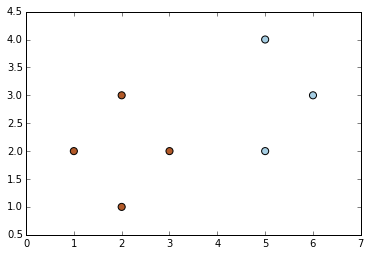

In [4]:
plot_problem(seven_X, seven_y)

## Zadatci

### 1. Implementacija logističke regresije

### (a)

Definirajte logističku (sigmoidalnu) funkciju $\mathrm{sigm}(x)=\frac{1}{1+\exp(-\alpha x)}$ i prikažite je za $\alpha\in\{1,2,4\}$.

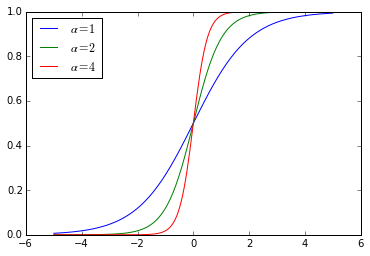

In [5]:
# Vaše rješenje...
def sigm(x):
    return 1./(1+np.exp(-x))

x = linspace(-5,5,200)

for a in [1,2,4]:
    plt.plot(x,sigm(x*a),label="$α=%d$"%a)
plt.legend(loc="best")
plt.show()

**Q**: Zašto je sigmoidalna funkcija prikladan izbor za aktivacijsku funkciju poopćenoga linearnog modela?

**Q**: Kakav utjecaj ima faktor $\alpha$ na oblik sigmoide? Što to znači za model logističke regresije (tj. kako aposteriorna vjerojatnost $P(\mathcal{C}_j|\mathbf{x})$ ovisi o magnitudi vektora težina $\mathbf{w}$)?

### (b)

Implementirajte funkciju 

> `lr_train(X, y, eta=0.01, max_iter=2000, alpha=0, epsilon=0.0001, trace=False)` 

za treniranje modela logističke regresije gradijentnim spustom (*batch* izvedba). Funkcija uzima označeni skup primjera za učenje (matrica primjera `X` i vektor oznaka `y`) te vraća $(n+1)$-dimenzijski vektor težina tipa `ndarray`. Ako je `trace=True`, funkcija dodatno vraća listu (ili matricu) vektora težina $\mathbf{w}^0,\mathbf{w}^1,\dots,\mathbf{w}^k$ generiranih kroz sve iteracije optimizacije, od 0 do $k$. Optimizaciju treba provoditi dok se ne dosegne `max_iter` iteracija, ili kada razlika u pogrešci unakrsne entropije između dviju iteracija padne ispod vrijednosti `epsilon`. Parametar `alpha` predstavlja faktor regularizacije.

Definirajte pomoćnu funkciju `lr_h(x,w)` koja daje predikciju (aposteriornu vjerojatnost) za primjer `x` uz zadane težine `w`.

**NB:** Obratite pozornost na to da je način kako su definirane oznake ($\{+1,-1\}$ ili $\{1,0\}$) kompatibilan s izračunom funkcije gubitka u optimizacijskome algoritmu. Prilagodite algoritam ili jednostavno redefinirajte oznake u skupu `seven`.

In [6]:
# Vaše rješenje...
def lr_h(x,w):
    return sigm(x.dot(w[1:])+w[0])

def err_cross_entropy(w,X,y):
    res = 0
    hx = lr_h(X,w)
    for i in range(len(y)):
        if hx[i] >= 1 :
            drugi = float("-inf")
        else:
            drugi = np.log(1-hx[i])
        if hx[i] <= 0 :
            prvi = float("-inf")
        else:
            prvi = np.log(hx[i])
    
        res -= y[i]*prvi-(1-y[i])*drugi
    return res

def lr_train(X, y, eta=0.01, max_iter=2000, alpha=0, epsilon=0.0001, trace=False):
    w = np.zeros(len(X[0])+1)
    diff = err_cross_entropy(w,X,y)
    prev = diff
    sol = np.array([])
    while(max_iter>0 and diff>=epsilon):
        max_iter=max_iter-1
        deltaw0 = 0
        deltaw = np.zeros(len(X[0]))
        for i in range(X.shape[0]) :
            h = lr_h(X[i],w)
            deltaw0 = deltaw0 + (h-y[i])
            deltaw = deltaw + (h-y[i])*X[i]
        w[0]=w[0]-eta*deltaw0
        w[1:]=(1-eta*alpha)*w[1:]-eta*deltaw
        if trace == True :
            if len(sol) == 0:
                sol = w
            else:
                sol = np.vstack([sol,w])
        else:
            sol=w
        curr = err_cross_entropy(w,X,y)
        diff = abs(prev-curr)
        prev = curr
    return sol

### (c)

Definirajte fukciju `cross_entropy_error(X,y,w)` koja izračunava pogrešku unakrsne entropije modela na označenom skupu `(X,y)`. Možete iskoristiti funkciju [`metrics.log_loss`](http://scikit-learn.org/stable/modules/generated/sklearn.metrics.log_loss.html).

In [7]:
from sklearn.metrics import log_loss
# Vaše rješenje...
def cross_entropy_error(X,y,w):
    return log_loss(y,lr_h(X,w))

### (d)

Koristeći funkciju `lr_train`, trenirajte model logističke regresije na skupu `seven`, prikažite dobivenu granicu između klasa te  izračunajte pogrešku unakrsne entropije.

E(w|D) = 0.0875088655181
w = [ 6.00160847 -2.01943477  0.56440866]


/home/ante/anaconda3/lib/python3.4/site-packages/matplotlib/collections.py:590: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors == str('face'):


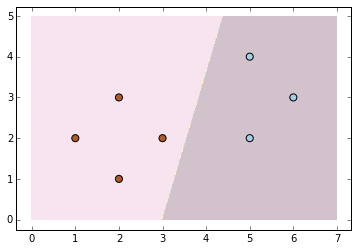

In [8]:
# Vaše rješenje...
w = lr_train(seven_X,seven_y)
print("E(w|D) = "+str(cross_entropy_error(seven_X,seven_y,w)))
plot_problem(seven_X, seven_y,lambda x : lr_h(x,w)>=0.5)
print("w = "+str(w))

**Q:** Jeste li dobili granicu između klasa kakvu ste očekivali dobiti pomoću logističke regresije? Obrazložite.

**Q:** Koji kriterij zaustavljanja je aktiviran?

**Q:** Zašto dobivena pogreška unakrsne entropije nije jednaka nuli?

**Q:** Kako biste utvrdili da je optimizacijski postupak doista pronašao hipotezu koja minimizira pogrešku učenja? O čemu (o kojim parametrima) to ovisi?

**Q:** Na koji način biste preinačili kod ako biste htjeli da se optimizacija izvodi stohastičkim gradijentnim spustom (*online learning*)?

### (e)

Prikažite na jednom grafikonu pogrešku unakrsne entropije (očekivanje logističkog gubitka) i pogrešku klasifikacije (očekivanje gubitka 0-1) na skupu `seven` kroz iteracije optimizacijskog postupka. Koristite trag težina funkcije `lr_train` iz zadatka (b) (opcija `trace=True`). Za izračun pogreške možete koristiti funkciju [`metrics.zero_one_loss`](http://scikit-learn.org/stable/modules/generated/sklearn.metrics.zero_one_loss.html#sklearn.metrics.zero_one_loss). Na drugom grafikonu prikažite pogrešku unakrsne entropije kao funkciju broja iteracija za različite stope učenja, $\eta\in\{0.005,0.01,0.05,0.1\}$.

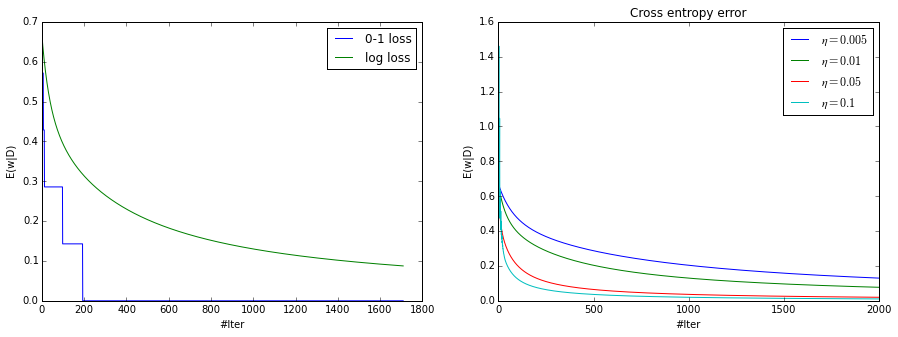

In [9]:
from sklearn.metrics import zero_one_loss

# Vaše rješenje...
fig = plt.figure(2,figsize=(15,5))
w = lr_train(seven_X,seven_y,trace=True)
z_o = []
cross_err = []
for i in range(w.shape[0]):
    hx = lr_h(seven_X,w[i])
    z_o.append(zero_one_loss(seven_y,hx>=0.5))
    cross_err.append(cross_entropy_error(seven_X,seven_y,w[i]))
fig.add_subplot("121")
plt.ylabel("E(w|D)")
plt.xlabel("#Iter")
plt.plot(range(w.shape[0]),z_o,label="0-1 loss")
plt.plot(range(w.shape[0]),cross_err,label="log loss")
plt.legend(loc="best")
fig.add_subplot("122")
plt.title("Cross entropy error")
plt.ylabel("E(w|D)")
plt.xlabel("#Iter")
for eta in [0.005,0.01,0.05,0.1]:
    w = lr_train(seven_X,seven_y,eta,epsilon=1e-6,trace=True)
    cross_err = []
    for i in range(w.shape[0]):
        cross_err.append(cross_entropy_error(seven_X,seven_y,w[i]))
    plt.plot(range(w.shape[0]),cross_err,label="$η = %g$"%eta)
plt.legend(loc="best")
plt.show()


**Q:** Zašto je pogreška unakrsne entropije veća od pogreške klasifikacije? Je li to uvijek slučaj kod logističke regresije i zašto?

**Q:** Koju stopu učenja $\eta$ biste odabrali i zašto?

### (f)

Upoznajte se s klasom [`linear_model.LogisticRegression`](http://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html) koja implementira logističku regresiju. Usporedite rezultat modela na skupu `seven` s rezultatom koji dobivate pomoću vlastite implementacije algoritma.

[[-2.04748669  0.40491036]]
[ 6.5489959]
w = [ 6.00160847 -2.01943477  0.56440866]


/home/ante/anaconda3/lib/python3.4/site-packages/matplotlib/collections.py:590: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors == str('face'):


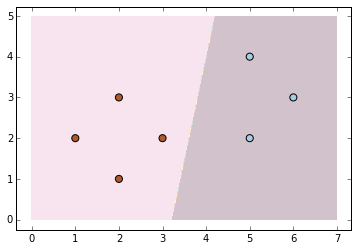

In [10]:
from sklearn.linear_model import LogisticRegression
# Vaše rješenje...
lr = LogisticRegression(C=48)
lr.fit(seven_X,seven_y)
print(lr.coef_)
print(lr.intercept_)
plot_problem(seven_X,seven_y,lambda x: lr.predict(x))
w = lr_train(seven_X,seven_y)
print("w = "+str(w))

**Q:** Ako se rezultat razlikuje, pokušajte obrazložiti zašto je to tako.

### 2. Analiza logističke regresije

### (a)

Dodajte u skup `seven` jednu vrijednost koja odskače od ostalih. Provjerite koliko je model logističke regresije robustan na vrijednosti koje odskaču. Prikažite granicu između klasa.

/home/ante/anaconda3/lib/python3.4/site-packages/matplotlib/collections.py:590: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors == str('face'):


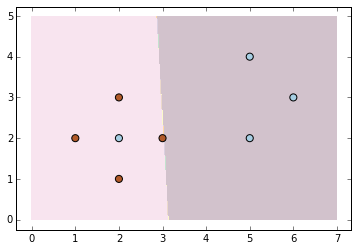

In [11]:
# Vaše rješenje...
seven_Xout = sp.vstack((seven_X,[2,2]))
seven_yout = sp.hstack((seven_y,[0]))
lr.fit(seven_Xout,seven_yout)
plot_problem(seven_Xout,seven_yout,lambda x: lr.predict(x))
w = lr_train(seven_Xout,seven_yout)


**Q:** Usporedite rezultat s onime za model linearne regresije iz druge laboratorijske vježbe, zadatak (8b). Obrazložite zašto se rezultat razlikuje.

### (b)

Trenirajte model logističke regresije na skupu `seven` te na dva odvojena grafikona prikažite (1) aposteriornu vjerojatnost $P(\mathcal{C}|\mathbf{x})$ za svih sedam primjera te (2) vrijednosti težina $w_0$, $w_1$, $w_2$ kroz iteracije optimizacijskoga algoritma. 




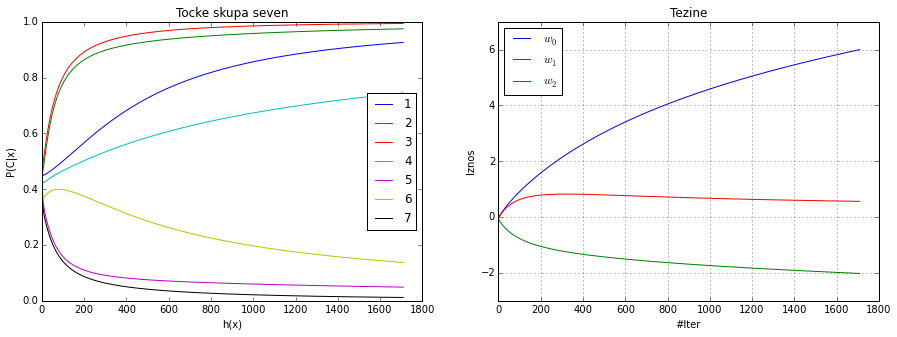

In [12]:
# Vaše rješenje...
def aposterior(y,x,w):
    h = lr_h(x,w)
    return h**y *(1-h)**(1-y)

def plot_tock_tez(X,y,iter=2000,epsilon=0.0001):
    fig = plt.figure(2,figsize=(15,5))
    fig.add_subplot("121")
    plt.title("Tocke skupa seven")
    plt.ylabel("P(C|x)")
    plt.xlabel("h(x)")
    w = lr_train(X,y,epsilon=epsilon,max_iter=iter,trace=True)
    for j in range(len(X)):
        prob = []
        for i in range(w.shape[0]):
                prob.append(aposterior(1,X[j],w[i]))
        plt.plot(range(w.shape[0]),prob,label="%d"%(j+1))
    #plt.plot(range(X.shape[0]),aposterior(0,X,w[-1]),label="$P(C_{0}|x)$")
    #plt.plot(range(X.shape[0]),aposterior(1,X,w[-1]),label="$P(C_{1}|x)$")
    plt.legend(loc="best")
    fig.add_subplot("122")
    plt.title("Tezine")
    plt.ylabel("Iznos")
    plt.xlabel("#Iter")
    for i in range(len(w[0])):
        plt.plot(range(w.shape[0]),w[:,i],label="$w_{%d}$"%i)
    grid()
    plt.legend(loc="best")
    plt.show()
    
plot_tock_tez(seven_X,seven_y)

### (c)

Preinačite skup `seven` tako da on više ne bude linearno odvojiv. Trenirajte model logističke regresije na takvom skupu te prikažite oba grafikona iz zadatka (b).

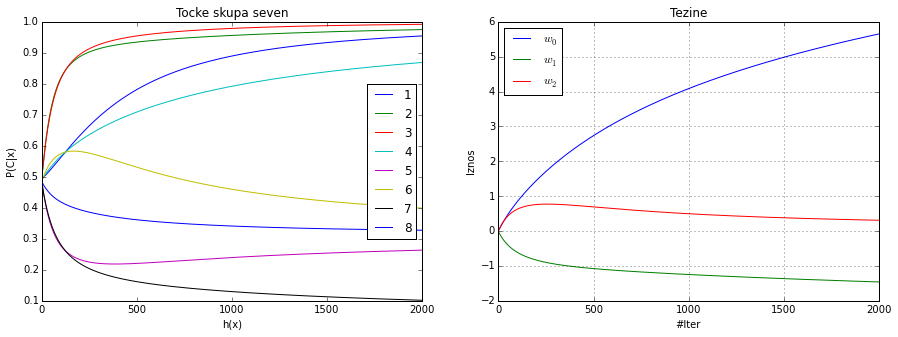

In [13]:
# Vaše rješenje...
seven_Xout = sp.vstack((seven_X,[5,3]))
seven_yout = sp.hstack((seven_y,[1]))
plot_tock_tez(seven_Xout,seven_yout,epsilon=1e-6)

**Q:** Usporedite grafikone za slučaj linearno odvojivih i linearno neodvojivih primjera te komentirajte razliku.

### 3. Regularizirana logistička regresija

### (a)

Trenirajte model logističke regresije na skupu `seven` s različitim faktorima L2-regularizacije, $\alpha\in\{0,1,10,100\}$. Prikažite (1) pogrešku unakrsne entropije te (2) L2-normu vektora $\mathbf{w}$ kroz iteracije optimizacijskog algoritma.

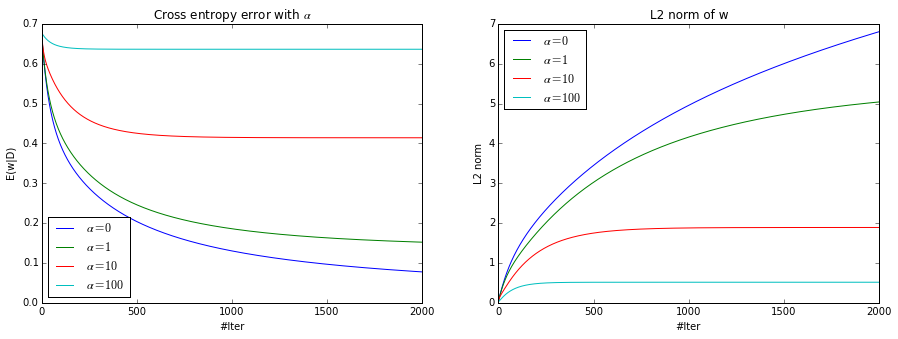

In [14]:
# Vaše rješenje...
fig = plt.figure(2,figsize=(15,5))
for alpha in [0,1,10,100]:
    w = lr_train(seven_X,seven_y,epsilon=1e-16,alpha=alpha,trace=True)
    cross_err = []
    nor = []
    for i in range(w.shape[0]):
        cross_err.append(cross_entropy_error(seven_X,seven_y,w[i]))
        nor.append(np.linalg.norm(w[i]))
    fig.add_subplot("121")
    plt.plot(range(w.shape[0]),cross_err,label="$α = %d$"%alpha)
    fig.add_subplot("122")
    plt.plot(range(w.shape[0]),nor,label="$α = %d$"%alpha)
fig.add_subplot("121")
plt.title("Cross entropy error with $α$")
plt.ylabel("E(w|D)")
plt.xlabel("#Iter")
plt.legend(loc="best")
fig.add_subplot("122")
plt.title("L2 norm of w")
plt.ylabel("L2 norm")
plt.xlabel("#Iter")
plt.legend(loc="best")
plt.show()

**Q:** Jesu li izgledi krivulja očekivani i zašto?

**Q:** Koju biste vrijednost za $\alpha$ odabrali i zašto?

### 4. Logistička regresija s funkcijom preslikavanja

### (a)

Proučite funkciju [`datasets.make_classification`](http://scikit-learn.org/stable/modules/generated/sklearn.datasets.make_classification.html). Generirajte i prikažite dvoklasan skup podataka s ukupno $N=100$ dvodimenzijskih ($n=2)$ primjera, i to sa dvije grupe po klasi (`n_clusters_per_class=2`). Malo je izgledno da će tako generiran skup biti linearno odvojiv, međutim to nije problem jer primjere možemo preslikati u višedimenzijski prostor značajki pomoću klase [`preprocessing.PolynomialFeatures`](http://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.PolynomialFeatures.html), kao što smo to učinili kod linearne regresije u drugoj laboratorijskoj vježbi. Trenirajte model logističke regresije koristeći za preslikavanje u prostor značajki polinomijalnu funkciju stupnja $d=2$ i stupnja $d=3$. Prikažite dobivene granice između klasa. Možete koristiti svoju implementaciju, ali se radi brzine preporuča koristiti `linear_model.LogisticRegression`. Regularizacijski faktor odaberite po želji.

**NB:** Kao i ranije, za prikaz granice između klasa koristite funkciju `plot_problem`. Funkciji kao argumente predajte izvorni skup podataka, a preslikavanje u prostor značajki napravite unutar poziva funkcije `h` koja čini predikciju, na sljedeći način:

In [15]:
from sklearn.preprocessing import PolynomialFeatures


/home/ante/anaconda3/lib/python3.4/site-packages/matplotlib/collections.py:590: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors == str('face'):


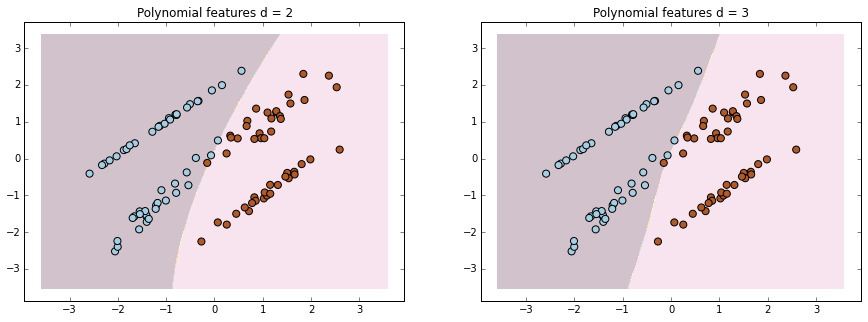

In [16]:
from sklearn.datasets import make_classification

X,y = make_classification(100,2,2,0,n_clusters_per_class=2,random_state=42)
fig = plt.figure(2,figsize=(15,5))
for i in [2,3]:
    fig.add_subplot("12"+str(i-1))
    plt.title("Polynomial features d = %d"%i)
    poly = PolynomialFeatures(i)
    model = LogisticRegression(C=48)
    X_fi = poly.fit_transform(X)
    model.fit(X_fi,y)
    plot_problem(X, y, lambda x : model.predict(poly.transform(x)))

**Q:** Koji biste stupanj polinoma upotrijebili i zašto? Je li taj odabir povezan s odabirom regularizacijskog faktora $\alpha$? Zašto?

### (b)

Podijelite skup podataka iz zadatka (a) na **skup za treniranje** i **skup za ispitivanje** u omjeru 7:3 (možete koristiti funkciju [`cross_validation.train_test_split`](http://scikit-learn.org/stable/modules/generated/sklearn.cross_validation.train_test_split.html). Na skupu za učenje trenirajte model logističke regresije s polinomom četvrtog stupnja ($d=4$) kao funkcijom preslikavanja. Prikažite empirijsku pogrešku i pogrešku generalizacije u ovisnosti o faktoru regularizacije, i to kao funkciju parametra $C$ (inverz faktora regularizacije) za $C=2^\alpha$, gdje $\alpha\in\{-8,-7,\dots,7,8\}$.

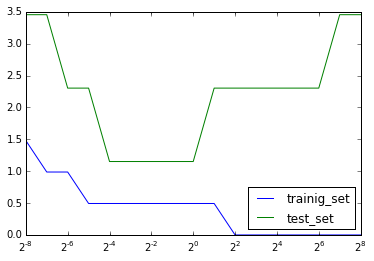

In [17]:
from sklearn.cross_validation import train_test_split

# Vaše rješenje...
X_train, X_test, y_train, y_test = train_test_split(X,y,train_size=0.7,random_state=11)
poly = PolynomialFeatures(4)
Xtil = poly.fit_transform(X_train)
training = []
test = []
rang = [ 2**x for x in sp.arange(-8,9)]
for c in rang:
    lr = LogisticRegression(C=c)
    lr.fit(Xtil,y_train)
    training.append(log_loss(y_train,lr.predict(Xtil)))
    test.append(log_loss(y_test,lr.predict(poly.fit_transform(X_test))))
plt.plot(rang,training,label='trainig_set')
plt.plot(rang,test,label='test_set')
xscale('log', basex=2)
plt.legend(loc='best')
plt.show()

**Q:** Kojem dijelu u grafikonu odgovara prenaučenost, a kojem podnaučenost? Zašto?

**Q:** Koji biste faktor $\alpha$ odabrali i zašto?

**Q:** Koliko su ovi rezultati stabilni? Ako mislite da nisu, objasnite što je mogući uzrok. Predložite kako bismo mogli dobiti stabilnije rezultate.

### 5. Klasifikator SVM

### (a)

Upoznajte se s klasom [`svm.SVC`](http://scikit-learn.org/stable/modules/generated/sklearn.svm.SVC.html#sklearn.svm.SVC), koja ustvari implementira sučelje prema implementaciji [`libsvm`](http://www.csie.ntu.edu.tw/~cjlin/libsvm/). Primijenite model `SVC` s linearnom jezgrenom funkcijom (tj. bez preslikavanja primjera u prostor značajki) na skup podataka `seven`. Prikažite dobivenu granicu između klasa, ispišite koeficijente $w_0$ i $\mathbf{w}$ te izračunajte širinu margine. Ispišite dualne koeficijente i potporne vektore.

w0 = [ 3.99951172], w = [[ -9.99707031e-01  -2.92968750e-04]]
dual coef: [[ -4.99707031e-01  -1.46484375e-04   4.99853516e-01]]
support vec:
[[ 5.  2.]
 [ 5.  4.]
 [ 3.  2.]]
Margin width = 2.00058602331


/home/ante/anaconda3/lib/python3.4/site-packages/matplotlib/collections.py:590: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors == str('face'):


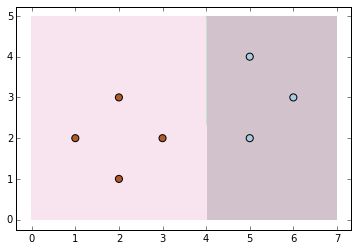

In [18]:
from sklearn.svm import SVC

# Vaše rješenje...
svc = SVC(kernel='linear')
svc.fit(seven_X, seven_y)
plot_problem(seven_X, seven_y, svc.predict)
print("w0 = " + str(svc.intercept_) +", w = " + str(svc.coef_) )
print("dual coef: "+ str(svc.dual_coef_))
print("support vec:\n"+str(svc.support_vectors_))
print("Margin width = " + str( 2/sp.linalg.norm(svc.coef_)))

### (b) 

Prisjetite se da $h(\mathbf{x})=\mathbf{w}^\intercal\tilde{\mathbf{x}}$ odgovara udaljenosti primjera $\mathbf{x}$ od granice definirane sa $h(\mathbf{x})=0$. Provjerite da je upravo to vrijednost koju izračunava funkcija `svm.decision_function`. Preinačite funkciju `plot_problem` tako da, uz granicu između klasa, prikazuje i marginu.


/home/ante/anaconda3/lib/python3.4/site-packages/matplotlib/collections.py:590: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors == str('face'):


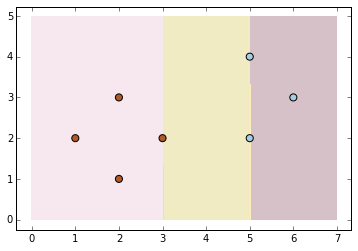

[[ 1.99980469  1.99921875  2.99921875  0.99980469 -0.99960938 -1.00019531
  -1.99960938]]
[ 1.99980469  1.99921875  2.99921875  0.99980469 -0.99960937 -1.00019531
 -1.99960938]


In [19]:
# Vaše rješenje...
def h(x,w):
    return x.dot(w[1:])+w[0]

def predict(model,x) : 
    hx = model.decision_function(x)
    for i in range(len(hx)):
        h = hx[i]
        if h >= -1 and h <= 1 : hx[i]=0.5
        else : hx[i] = max(-1,min(1,h))
    return hx

plot_problem(seven_X, seven_y, lambda x : predict(svc,x))
show();
w = np.array((svc.intercept_))
w = np.column_stack((w,svc.coef_)).reshape(3,1)
print(h(seven_X,w).reshape(1,7))
print(svc.decision_function(seven_X))


**Q:** Koliko iznosi širina margine i zašto?

**Q:** Koji primjeri su potporni vektori i zašto?

### (c)

Definirajte funkciju `hinge(model,x,y)` koja izračunava gubitak zglobnice modela SVM na primjeru `x`. Izračunajte gubitke modela naučenog na skupu `seven` za primjere $\mathbf{x}^{(1)}=(3,2)$, $\mathbf{x}^{(1)}=(3.5,2)$ i $\mathbf{x}^{(3)}=(4,2)$ koji su označeni pozitivno ($y=1$). Također izračunajte prosječni gubitak SVM-a na skupu `seven`. Uvjerite se da je rezultat identičan onome koji biste dobili primjenom ugrađene funkcije [`metrics.hinge_loss`](http://scikit-learn.org/stable/modules/generated/sklearn.metrics.hinge_loss.html). 

In [20]:
from sklearn.metrics import hinge_loss

# Vaše rješenje...
def hinge(model,x,y):
    h = model.decision_function(x)
    for i in range(len(h)):
        h[i] = 1-h[i]*y[i]
        if h[i] <= 0 : h[i] = 0 
    return h
seven_X_t = sp.array([[3,2],[3.5,2],[4,2]])
seven_y_t = sp.array([1,1,1])
print("Gubitak modela = " + str(sum(hinge(svc,seven_X_t,seven_y_t))))
seven_y_t = sp.array((seven_y))
seven_y_t[seven_y_t==0] = -1
print(sum(hinge(svc,seven_X,seven_y_t))/len(seven_y))
print(hinge_loss(seven_y,svc.decision_function(seven_X)))

Gubitak modela = 1.50014648437
8.37053571429e-05
8.37053571429e-05


### 6. Usporedba linearnih modela

### (a)

Trenirajte na skupu `seven` tri linearna modela: perceptron, logističku regresiju i linearan SVM. Prikažite dobivenu granicu između klasa za sva tri modela. 

/home/ante/anaconda3/lib/python3.4/site-packages/matplotlib/collections.py:590: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors == str('face'):


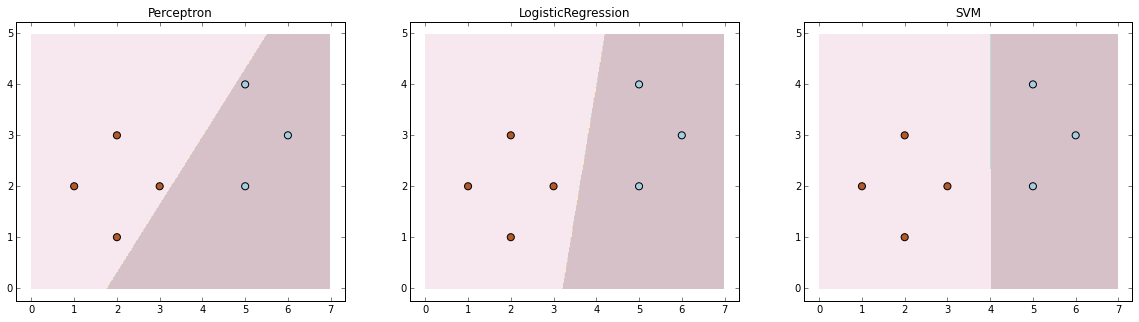

In [21]:
from sklearn.linear_model import Perceptron, LogisticRegression

# Vaše rješenje...
def print_6(X,y):
    fig = plt.figure(3,figsize=(20,5))
    fig.add_subplot("131")
    plt.title("Perceptron")
    percep = Perceptron(shuffle=True,n_iter=51,random_state=42)
    percep.fit(X,y)
    plot_problem(X,y,percep.predict)
    fig.add_subplot("132")
    plt.title("LogisticRegression")
    lr = LogisticRegression(C=48)
    lr.fit(X,y)
    plot_problem(X,y,lr.predict)
    fig.add_subplot("133")
    plt.title("SVM")
    svc = SVC(kernel='linear')
    svc.fit(X, y)
    plot_problem(X, y, svc.predict)
seven_y_t= sp.array((seven_y))
seven_y_t[seven_y==0] = -1
print_6(seven_X,seven_y_t)

### (b)

Ponovite treniranje gornjih triju modela na skupu s dodatnim, osmim primjerom koji odskače te prikažite opet dobivene granice između klasa za sva tri modela.

/home/ante/anaconda3/lib/python3.4/site-packages/matplotlib/collections.py:590: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors == str('face'):


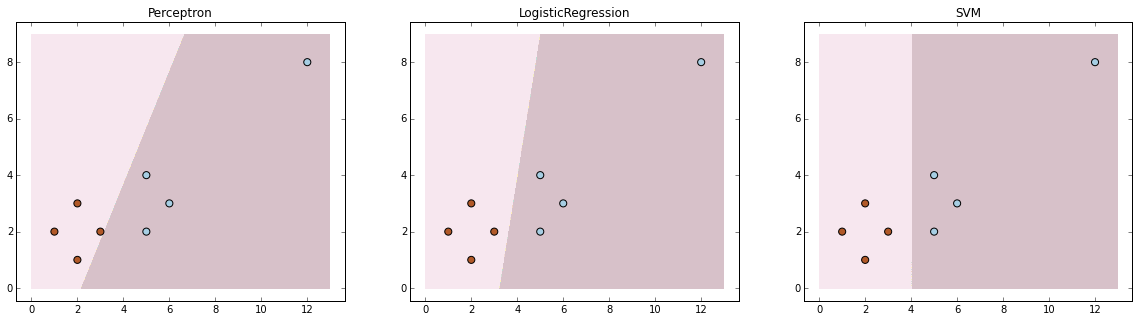

In [22]:
# Vaše rješenje...
seven_Xout = sp.vstack((seven_X,[12,8]))
seven_yout = sp.hstack((seven_y_t,[-1]))
print_6(seven_Xout,seven_yout)

**Q:** Jesu li rezultati očekivani? Obrazložite.

### 7. Nelinearan SVM

Razmotrimo sljedeći linearno nedovojiv skup podataka:

/home/ante/anaconda3/lib/python3.4/site-packages/matplotlib/collections.py:590: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors == str('face'):


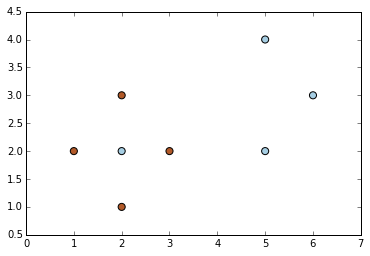

In [23]:
X2, y2 = sp.append(seven_X, [[2,2]], axis=0), sp.append(seven_y, 0)
plot_problem(X2, y2)

Na tom skupu trenirajte tri modela SVM s različitim jezgrenim funkcijama: linearnom, polinomijalnom i radijalnom baznom (RBF) funkcijom. Varirajte parametar $C$ po vrijednostima $C\in\{10^{-2},1,10^2\}$, dok za ostale parametre (stupanj polinoma za polinomijalnu jezgru odnosno parametar $\gamma$ za jezgru RBF) koristite podrazumijevane vijednosti. Prikažite granice između klasa (i margine) na grafikonu organiziranome u polje $3x3$, gdje su stupci različite jezgre, a retci različite vrijednosti parametra $C$.

/home/ante/anaconda3/lib/python3.4/site-packages/matplotlib/collections.py:590: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors == str('face'):


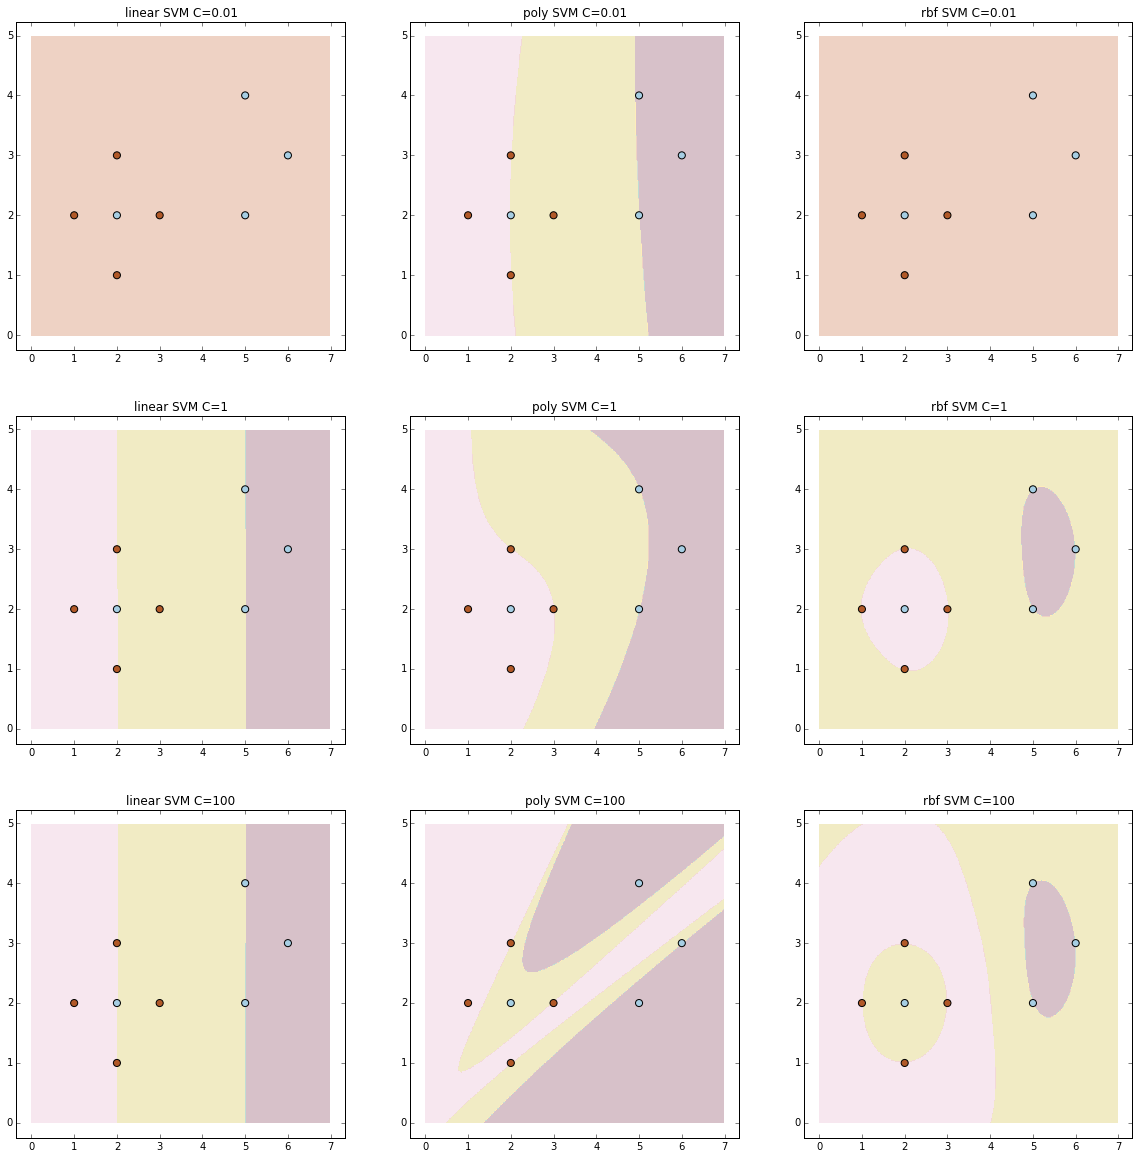

In [24]:
# Vaše rješenje...
fig = plt.figure(9,figsize=(20,20))
for i, c in enumerate([1e-2,1,1e2]):
    for j,model  in enumerate(["linear", "poly", "rbf"]):
        fig.add_subplot("33"+str(i*3+j+1))
        plt.title(model+" SVM C=%g"%c)
        svc = SVC(C=c,kernel=model)
        svc.fit(X2,y2)
        plot_problem(X2,y2,lambda x : predict(svc,x))

### 8. Optimizacija hiperparametara SVM-a

Pored hiperparametra $C$, model SVM s jezgrenom funkcijom RBF ima i dodatni hiperparametar $\gamma=\frac{1}{2\sigma^2}$ (preciznost). Taj parametar također određuje složenost modela: velika vrijednost za $\gamma$ znači da će RBF biti uska, primjeri će biti preslikani u prostor u kojem su (prema skalarnome produktu) međusobno vrlo različiti, što će rezultirati složenijim modelima. Obrnuto, mala vrijednost za $\gamma$ znači da će RBF biti široka, primjeri će biti međusobno sličniji, što će rezultirati jednostavnijim modelima. To ujedno znači da, ako odabremo veći $\gamma$, trebamo jače regularizirati model, tj. trebamo odabrati manji $C$, kako bismo spriječili prenaučenost. Zbog toga je potrebno zajednički optimirati hiperparametre $C$ i $\gamma$, što se tipično radi iscrpnim pretraživanjem po rešetci (engl. *grid search*). 

Definirajte funkciju 

> `grid_search(model, X_train, X_validate, y_train, y_validate, (c1,c2), (g1,g2), error_surface=False)` 

koja optimizira parametre $C$ i $\gamma$ pretraživanjem po rešetci. Funkcija treba pretražiti parametre $C\in\{2^{c_1},2^{c_1+1},\dots,2^{c_2}\}$ i $\gamma\in\{2^{g_1},2^{g_1+1},\dots,2^{g_2}\}$. Funkcija treba vratiti optimalne parametre $(C^*,\gamma^*)$, tj. one za koje na skupu za provjeru model ostvaruju najmanju pogrešku. Dodatno, ako je `surface=True`, funkcija treba vratiti matrice (tipa `ndarray`) pogreške modela (očekivanje gubitka 0-1) na skupu za učenje i skupu za provjeru. Svaka je matrica dimenzija $(c_2-c_1+1)\times(g_2-g_1+1)$ (retci odgovaraju različitim vrijednostima za $C$, a stupci različitim vrijednostima za $\gamma$).

Pomoću funkcije `datasets.make_classification` generirajte **dva** skupa podataka od $N=200$ primjera: jedan s $n=2$ dimenzije i drugi s $n=1000$ dimenzija. Primjeri neka dolaze iz dviju klasa, s time da svakoj klasi odgovaraju dvije grupe (`n_clusters_per_class=2`), kako bi problem bio nešto složeniji, tj. nelinearniji. Podijelite skup primjera na skup za učenje i skup za ispitivanje u omjeru 1:1.

In [25]:
from sklearn.datasets import make_classification
from sklearn.cross_validation import train_test_split

Na oba skupa optimirajte SVM s jezgrenom funkcijom RBF, u rešetci $C\in\{2^{-5},2^{-4},\dots,2^{15}\}$ i $\gamma\in\{2^{-15},2^{-14},\dots,2^{3}\}$. Prikažite površinu pogreške modela na skupu za učenje i skupu za provjeru, i to na oba skupa podataka (ukupno četiri grafikona) te ispišite optimalne kombinacije hiperparametara. Prikažite i granicu između klasa za dvodimenzijski skup. Za prikaz površine pogreške modela možete koristiti sljedeću funkciju:

In [26]:
def plot_error_surface(err,c,g) :
    xticks(range(0,g[1]-g[0]+1,5),range(g[0],g[1],5)); xlabel("gamma")
    yticks(range(0,c[1]-c[0]+1,5),range(c[0],c[1],5)); ylabel("C")
    p = contour(err);
    imshow(1-err, interpolation='bilinear', origin='lower',cmap=cm.gray)
    clabel(p, inline=1, fontsize=10);

In [27]:
# Vaše rješenje...
def grid_search(model, X_train, X_validate, y_train, y_validate, c, g, error_surface=False):
    best_c = 2**c[0];
    best_g = 2**g[0];
    min_err = float("inf")
    C_range = 2.**np.arange(c[0],c[1]+1)
    gamma_range = 2. ** np.arange(g[0],g[1]+1)
    if error_surface == True :
        test_10_loss = np.zeros((C_range.shape[0],gamma_range.shape[0]))
        train_10_loss = np.zeros((C_range.shape[0],gamma_range.shape[0]))
    for i,r in enumerate(C_range):
        train_10 = []
        test_10 = []
        for j,s in enumerate(gamma_range):
            svc = SVC(kernel=model,C=r,gamma=s)
            svc.fit(X_train,y_train)
            err = zero_one_loss(y_validate,svc.predict(X_validate))
            #err = hinge_loss(y_validate,svc.decision_function(X_validate))
            if err < min_err:
                min_err = err
                best_c = r
                best_g = s
            if error_surface == True :
                train_10_loss[i][j] = zero_one_loss(y_train,svc.predict(X_train))
                test_10_loss[i][j] = err
                #train_10.append(zero_one_loss(y_train,svc.predict(X_train)))
                #test_10.append(err)
        #train_10_loss.append(train_10)
        #test_10_loss.append(test_10)
    if error_surface == True :
        return best_c, best_g, np.array((train_10_loss)), np.array((test_10_loss))
    else:
        return best_c, best_g

/home/ante/anaconda3/lib/python3.4/site-packages/matplotlib/collections.py:650: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors_original != str('face'):
/home/ante/anaconda3/lib/python3.4/site-packages/matplotlib/collections.py:590: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors == str('face'):


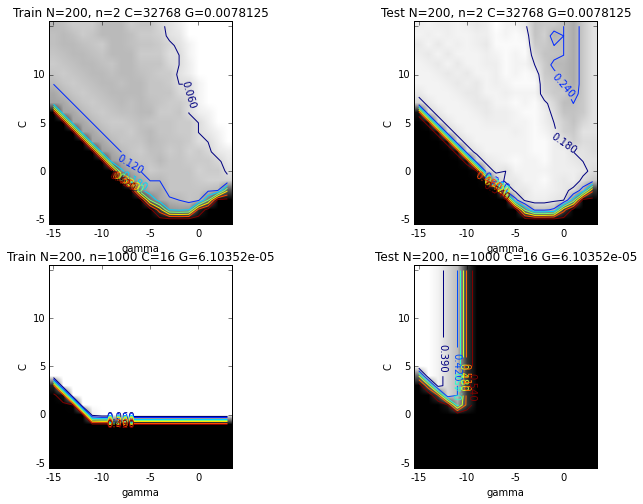

In [28]:
c = (-5,15)
g = (-15,3)
fig = plt.figure(4,figsize=(12,8))
counter = 1
for i,n in enumerate([2,1000]):
    X,y = make_classification(200,n,2,0,n_clusters_per_class=2,random_state=42)
    X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.5,random_state=42)
    best_c, best_g, train_10_loss, test_10_loss = grid_search("rbf",X_train, X_test, y_train, y_test,c,g,True)
    fig.add_subplot("22"+str(counter))
    counter = counter + 1
    plt.title("Train N=200, n=%d C=%g G=%g"%(n,best_c,best_g))
    plot_error_surface(train_10_loss,c,g)
    fig.add_subplot("22"+str(counter))
    counter = counter + 1
    plt.title("Test N=200, n=%d C=%g G=%g"%(n,best_c,best_g))
    plot_error_surface(test_10_loss,c,g)

/home/ante/anaconda3/lib/python3.4/site-packages/matplotlib/collections.py:590: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors == str('face'):


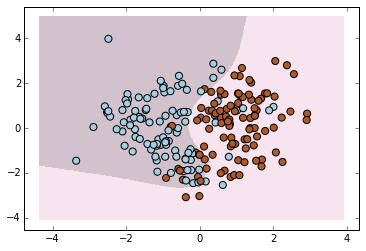

In [29]:
X,y = make_classification(200,2,2,0,n_clusters_per_class=2,random_state=42)
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.5,random_state=45)
best_c, best_g, train_10_loss, test_10_loss = grid_search("rbf",X_train, X_test, y_train, y_test,c,g,True)   
svc = SVC(C=best_c,gamma=best_g)
svc.fit(X,y)
plot_problem(X,y,svc.predict)

**Q:** Razlikuje li se površina pogreške na skupu za učenje i skupu za ispitivanje? Zašto?

**Q:** U prikazu površine pogreške, koji dio površine odgovara prenaučenosti, a koji podnaučenosti? Zašto?
    
**Q:** Koliko su ovi rezultati stabilni s obzirom na skup podataka? Pokažite.
    
**Q:** Kako broj dimenzija $n$ utječe na površinu pogreške, odnosno na optimalne hiperparametre $(C^*, \gamma^*)$?
    
**Q:** Preporuka je da povećanje vrijednosti za $\gamma$ treba biti popraćeno smanjenjem vrijednosti za $C$. Govore li vaši rezultati u prilog toj preporuci? Obrazložite.
    
**Q:** Podrazumijevana vrijednost parametara je $C=1$ i $\gamma=1/n$. Bi li te vrijednosti bile optimalne u ovom slučaju?

### *9. Kapacitet linearnog SVM-a

<span style="color:green">(Rješavanje ovog zadatka nije obavezno već donosi dodatne bodove.)</span>

Model s jezgrenom funkcijom (pogotovo RBF) je nelinearan, pa je u praksi (uz propisnu optimizaciju hiperparametara) za većinu problema bolji izbor nego linearan model. Međutim, za probleme kod kojih je broj dimenzija $n$ znatno veći od broja primjera $N$, linearan model može biti jednako dobar, jer tada postaje razmjerno lako i hiperravninom razdvojiti primjere u ulaznome prostoru. S druge strane, kod problema kod kojih je broj značajki znatno manji od broja primjera, vjerojatnije je da je problem nelinearan, pa je bolje koristiti SVM s jezgrenom funkcijom. Svrha ovog zadatka jest empirijski provjeriti je li to stvarno slučaj.

Pomoću [`datasets.make_classification`](http://scikit-learn.org/stable/modules/generated/sklearn.datasets.make_classification.html) generirajte dva dvoklasna skupa podataka: jedan sa $N=1000$ primjera i $n=2$ značajki te drugi sa $N=100$ primjera i $n=1000$ značajki. Svaki skup podijelite na skup za učenje i skup za provjeru u omjeru 1:1. Na skupovima za treniranje trenirajte dva modela: linearan SVM i SVM s jezgrenom funkcijom RBF. Na skupovima za provjeru napravite optimizaciju hiperparametra $C$ (za linearan model) odnosno hiperparametara $C$ i $\gamma$ (za nelinearan model), koristeći `grid_search` i raspone pretraživanja iz prethodnog zadatka (za optimizaciju samo parametra $C$ stavite `(g1,g2)=(1,1)`). Ispišite točnost obaju modela na skupu za učenje i na skupu za provjeru. Kako biste dobili robusnije procjene točnosti, eksperiment možete ponoviti više puta (npr. 5, 10 ili 30) te uprosječiti rezultate (u tom slučaju unutar petlje svaki puta nanovo generirajte oba skupa podataka).

**NB:** Ne zaboravite nanovo optimizirati hiperparametre na svakom generiranom skupu. Ako ponavljate postupak, imajte na umu da je zbog pretraživanja po rešetci on računalno zahtjevan, te da je treniranje modela s više značajki sporije.

In [30]:
# Vaše rješenje...
from sklearn.metrics import accuracy_score
def fun(model,X_train, X_test, y_train, y_test,c,g,err):
    best_c, best_g = grid_search(model,X_train, X_test, y_train, y_test,c,g)
    svc = SVC(kernel=model,C=best_c,gamma=best_g)
    svc.fit(X_train,y_train)
    #err[0] = err[0] + zero_one_loss(y_train,svc.predict(X_train))
    #err[1] = err[1] + zero_one_loss(y_test,svc.predict(X_test))
    #err[0] = err[0] + sum(svc.predict(X_train)==y_train)/float(len(y_train))
    #err[1] = err[1] + sum(svc.predict(X_test)==y_test)/float(len(y_test))
    #err[0] = err[0] + hinge_loss(y_train,svc.decision_function(X_train))
    #err[1] = err[1] + hinge_loss(y_test,svc.decision_function(X_test))    
    err[0] = err[0] + accuracy_score(y_train,svc.predict(X_train))
    err[1] = err[1] + accuracy_score(y_test,svc.predict(X_test))
    return err

In [31]:
c = (-15,15)
g = (-15,3)
error_lin = np.array(([0., 0.],[0., 0.]))
error_rbf = np.array(([0., 0.],[0., 0.]))
N = 10
for i in range(N):
    print(i)
    X1,y1 = make_classification(1000,2,2,0,n_clusters_per_class=2,random_state=42+i)
    X1_train, X1_test, y1_train, y1_test = train_test_split(X1,y1,test_size=0.5,random_state=45+i)
    X2,y2 = make_classification(100,1000,2,0,n_clusters_per_class=2,random_state=42+i)
    X2_train, X2_test, y2_train, y2_test = train_test_split(X2,y2,test_size=0.5,random_state=45+i)
    
    
    error_lin[0] = fun("linear",X1_train, X1_test, y1_train, y1_test,c,(1,1),error_lin[0])
    error_rbf[0] = fun("rbf",X1_train, X1_test, y1_train, y1_test,c,g,error_rbf[0])
    
    error_lin[1] = fun("linear",X2_train, X2_test, y2_train, y2_test,c,(1,1),error_lin[1])
    error_rbf[1] = fun("rbf",X2_train, X2_test, y2_train, y2_test,c,g,error_rbf[1])

0
1
2
3
4
5
6
7
8
9


In [32]:
print("N = 1000, n = 2")
print("Linear:\n\tTrain acc: %g"% (error_lin[0][0]/N))
print("\tTest acc: %g"%(error_lin[0][1]/N))
print("RBF:\n\tTrain acc: %g"%(error_rbf[0][0]/N))
print("\tTest acc: %g"%(error_rbf[0][1]/N))
print("\n\nN = 100, n = 1000")
print("Linear:\n\tTrain acc: %g"%(error_lin[1][0]/N))
print("\tTest acc: %g"%(error_lin[1][1]/N))
print("RBF:\n\tTrain acc: %g"%(error_rbf[1][0]/N))
print("\tTest acc: %g"%(error_rbf[1][1]/N))

N = 1000, n = 2
Linear:
	Train acc: 0.9134
	Test acc: 0.9084
RBF:
	Train acc: 0.9368
	Test acc: 0.9306


N = 100, n = 1000
Linear:
	Train acc: 1
	Test acc: 0.576
RBF:
	Train acc: 1
	Test acc: 0.594


**Q:** Jesu li rezultati očekivani? Obrazložite.
    
**Q:** Prema [Coverovom teoremu](http://en.wikipedia.org/wiki/Cover%27s_theorem), preslikavanjem problema u prostor više dimenzije povećava se vjerojatnost da je problem linearno odvojiv. Ako je to doista tako, zašto linearan model u ovom eksperimentu za slučaj kada $n\gg N$ ostvaruje manju točnost nego za slučaj kada $N\gg n$?

### 10. Višeklasna klasifikacija SVM-om

Kao i sve binarne klasifikatore, SVM je moguće primijeniti na višeklasifikacijski problem transformacijom problema u skup binarnih problema te primjenom sheme OVO ili OVR. U slučaju višeklasnog problema, standardna implementacija [`svm.SVC`](http://scikit-learn.org/stable/modules/generated/sklearn.svm.SVC.html) to automatski prepoznaje i primjenjuje shemu OVO. Generirajte četveroklasni skup primjera, trenirajte SVM s jezgrenom funkcijom RBF i podrazumijevanim vrijednostima za $C$ i $\gamma$ te prikažite dobivene rezultate.

/home/ante/anaconda3/lib/python3.4/site-packages/matplotlib/collections.py:590: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors == str('face'):


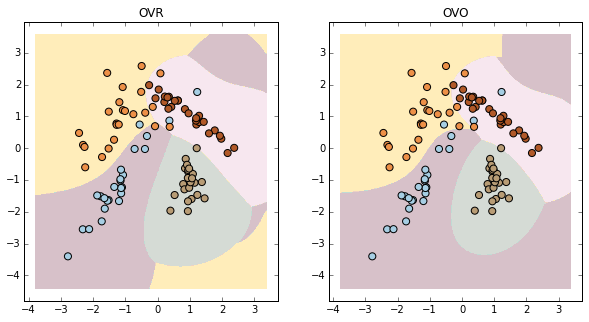

In [33]:
from sklearn.multiclass import OneVsRestClassifier, OneVsOneClassifier

# Vaše rješenje...
fig = plt.figure(2,figsize=(10,5))
X,y = make_classification(100,2,2,0,n_classes=4,n_clusters_per_class=1,random_state=45)
svc = SVC()
ovr = OneVsRestClassifier(svc)
ovr.fit(X,y)
fig.add_subplot(1,2,1)
plt.title("OVR")
plot_problem(X,y,ovr.predict)

ovo = OneVsOneClassifier(svc)
ovo.fit(X,y)
fig.add_subplot(1,2,2)
plt.title("OVO")
plot_problem(X,y,ovo.predict)

**Q:** Koliko je binarnih klasifikatora trenirano u ovom slučaju?

**Q:** Što su prednosti, a što nedostatci sheme OVO nad shemom OVR? Što mislite, zašto je shema OVO bolji izbor za SVM od sheme OVR?

### *11. Utjecaj skaliranja značajki kod SVM-a

<span style="color:green">(Rješavanje ovog zadatka nije obavezno već donosi dodatne bodove.)</span>

Za mnoge je modele bitno prije treniranja skalirati značajke, kako bi se spriječilo da značajke s većim numeričkim rasponima dominiraju nad onima s manjim numeričkim rasponima. To vrijedi i za SVM, kod kojega skaliranje nerijetko može znatno poboljšati rezultate. Svrha ovog zadataka jest eksperimentalno utvrditi utjecaj skaliranja značajki na točnost SVM-a.

Generirat ćemo dvoklasni skup od $N=500$ primjera s $n=2$ značajke, tako da je dimenzija $x_1$ većeg iznosa i većeg raspona od dimenzije $x_0$, te ćemo dodati jedan primjer koji vrijednošću značajke $x_1$ odskače od ostalih primjera:

/home/ante/anaconda3/lib/python3.4/site-packages/matplotlib/collections.py:590: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors == str('face'):


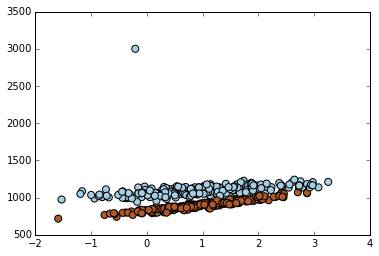

In [34]:
from sklearn.datasets import make_classification

X, y = make_classification(n_samples=500,n_features=2,n_classes=2,n_redundant=0,n_clusters_per_class=1,random_state=45)
X[:,1] = X[:,1]*100+1000
X[0,1] = 3000

plot_problem(X,y)

### (a)

Proučite klase [`preprocessing.StandardScaler`](http://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.StandardScaler.html) i [`preprocessing.MinMaxScaler`](http://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.MinMaxScaler.html#sklearn.preprocessing.MinMaxScaler). Proučite funkciju za iscrtavanje histograma [`hist`](http://matplotlib.org/api/pyplot_api.html). Prikažite histograme vrijednosti značajki $x_0$ i $x_1$ i to za neskalirane (izvorne) značajke, značajke skalirane standardizacijom i značajke skalirane min-max skaliranjem (ukupno šest histograma).

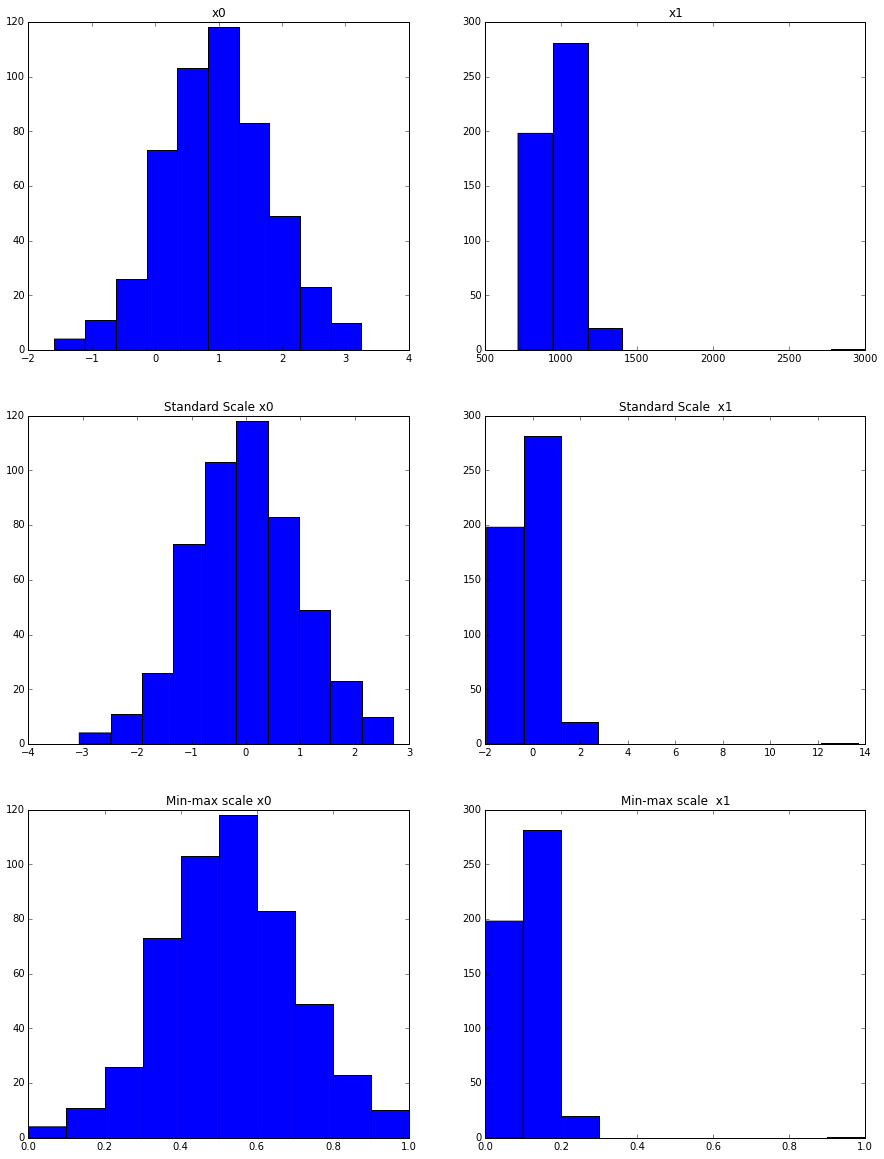

In [35]:
from sklearn.preprocessing import StandardScaler, MinMaxScaler

# Vaše rješenje...
fig = plt.figure(6,figsize=(15,20))
fig.add_subplot(321)
plt.title("x0")
plt.hist(X[:,0])
fig.add_subplot(322)
plt.title("x1")
plt.hist(X[:,1])

ss = StandardScaler()
xs = ss.fit_transform(X)
fig.add_subplot(323)
plt.title("Standard Scale x0")
plt.hist(xs[:,0])
fig.add_subplot(324)
plt.title("Standard Scale  x1")
plt.hist(xs[:,1])

mms = MinMaxScaler()
xm = mms.fit_transform(X)
fig.add_subplot(325)
plt.title("Min-max scale x0")
plt.hist(xm[:,0])
fig.add_subplot(326)
plt.title("Min-max scale  x1")
plt.hist(xm[:,1])

plt.show()

### (b) 
Podijelite skup primjera na skup za učenje i skup za ispitivanje u omjeru 1:1. Trenirajte SVM s jezgrenom funkcijom RBF na skupu za učenje i ispitajte točnost modela na skupu za ispitivanje, koristeći tri varijante gornjeg skupa: neskalirane značajke, standardizirane značajke i min-max skaliranje. Koristite podrazumijevane vrijednosti za $C$ i $\gamma$. Izmjerite točnost svakog od triju modela na skupu za učenje i skupu za ispitivanje. Ponovite postupak više puta (npr. 30) te uprosječite rezultate.

**NB:** Kod skaliranja značajki treba paziti da ne dođe do "curenja informacija" sa skupa za učenje na skup za ispitivanje. Na skupu za učenje treba najprije izračunati parametre skaliranja te zatim primijeniti skaliranje (funkcija `fit_transform`), dok na skupu za ispitivanje treba samo primijeniti skaliranje s parametrima koji su dobiveni na skupu za učenje (funkcija `transform`).

In [36]:
# Vaše rješenje...
normal = np.array([0.,0.])
scale = np.array([0.,0.])
minmax = np.array([0.,0.])
N = 100
for i in range(N):
    X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.5,random_state=42+i)
    svc = SVC()
    svc.fit(X_train,y_train)
                            
    normal[0] = normal[0] + sum(svc.predict(X_train)==y_train)/float(len(y_train))
    normal[1] = normal[1] + sum(svc.predict(X_test)==y_test)/float(len(y_test))
    #normal[0] = normal[0] + hinge_loss(y_train,svc.decision_function(X_train))
    #normal[1] = normal[1] + hinge_loss(y_test,svc.decision_function(X_test))  
    
    ss = StandardScaler()
    xs = ss.fit_transform(X_train)
    svc = SVC()
    svc.fit(xs,y_train)
    scale[0] = scale[0] + sum(svc.predict(xs)==y_train)/float(len(y_train))
    scale[1] = scale[1] + sum(svc.predict(ss.transform(X_test))==y_test)/float(len(y_test))
    #scale[0] = scale[0] + hinge_loss(y_train,svc.decision_function(xs))
    #scale[1] = scale[1] + hinge_loss(y_test,svc.decision_function(ss.transform(X_test)))
    
    mms = MinMaxScaler()
    xm = mms.fit_transform(X_train)
    svc = SVC()
    svc.fit(xm,y_train)
    minmax[0] = minmax[0] + sum(svc.predict(xm)==y_train)/float(len(y_train))
    minmax[1] = minmax[1] + sum(svc.predict(mms.transform(X_test))==y_test)/float(len(y_test))
    #minmax[0] = minmax[0] + hinge_loss(y_train,svc.decision_function(xm))
    #minmax[1] = minmax[1] + hinge_loss(y_test,svc.decision_function(mms.transform(X_test)))

In [37]:
print("Bez skalacije")
print("\tTrain acc: %g"% (normal[0]/N))
print("\tTest acc: %g"%(normal[1]/N))
print("Standard scale")
print("\tTrain acc: %g"% (scale[0]/N))
print("\tTest acc: %g"%(scale[1]/N))
print("Min-max scale")
print("\tTrain acc: %g"% (minmax[0]/N))
print("\tTest acc: %g"%(minmax[1]/N))

Bez skalacije
	Train acc: 0.99828
	Test acc: 0.91728
Standard scale
	Train acc: 0.99568
	Test acc: 0.99416
Min-max scale
	Train acc: 0.9266
	Test acc: 0.91652


**Q:** Jesu li rezultati očekivani? Obrazložite.

**Q:** Bi li bilo dobro kada bismo funkciju `fit_transform` primijenili na cijelom skupu podataka? Zašto? Bi li bilo dobro kada bismo tu funkciju primijenili zasebno na skupu za učenje i zasebno na skupu za ispitivanje? Zašto?

### *12. Klasifikacija vrste stakla

<span style="color:green">(Rješavanje ovog zadatka nije obavezno već donosi dodatne bodove.)</span>

Preuzmite [`Glass Identification Data Set`](https://archive.ics.uci.edu/ml/datasets/Glass+Identification), koji opisuje rezultate kemijske analize 214 stakala. Riječ je o klasifikacijskom problemu sa šest klasa: na temelju 9 kemijskih značajki stakla potrebno je, u svrhu forenzičke analize, odrediti o kojoj se od šest vrsta stakla radi. Skup podataka možete učitati na sljedeći način:

In [38]:
data = sp.loadtxt('/home/ante/Desktop/glass.data', delimiter=',')
glass_X, glass_y = data[:,1:10], data[:,10]

Skup zatim podijelite na skup za učenje i skup za ispitivanje u omjeru 2:1, kako slijedi:

In [39]:
from sklearn import cross_validation
X_train, X_test, y_train, y_test = cross_validation.train_test_split(glass_X, glass_y, train_size=2.0/3, random_state=42)
print(X_train.shape, X_test.shape)

(142, 9) (72, 9)


Na skupu za učenje trenirajte dva modela: logističku regresiju i SVM. Za oba model ispitajte linearne i nelinearne varijante. Također, za oba modela načinite optimizaciju hiperparametara, i to:

* faktora regularizacije $\alpha$ za logističku regresiju,
* hiperparametra $C$ za linearan SVM,
* hiperparametara $C$ i $\gamma$ za nelinearan SVM.

Optimizaciju hiperparametara načinite na skupu za provjeru, koji ćete dobiti dodatnom podjelom skupa za učenje, dok točnost modela ispitajte na skupu za ispitivanje. Skup za ispitivanje ne smijete koristiti ni za što osim za **konačno i jednokratno** vrednovanje točnosti modela!

U ovom skupu podataka značajke dolaze iz različitih distribucija, što može dovesti do toga da značajke s većim numeričkim vrijednostima dominiraju nad značajkama s manjim numeričkim vrijednostima, a to u konačnici može narušiti kvalitetu modela. Problem se može ublažiti standardizacijom značajki, kao što smo radili u drugoj laboratorijskoj vježbi. Proučite klasu za skaliranje značajki [`preprocessing.StandardScaler`](http://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.StandardScaler.html#sklearn.preprocessing.StandardScaler) i primijenite skaliranje značajki. Pritom iskoristite uvide iz prethodnoga zadatka. 

Ispišite točnost svih modela na skupu za učenje i na skupu za ispitivanje.

In [49]:
from sklearn.grid_search import GridSearchCV
from sklearn.preprocessing import StandardScaler

# Vaše rješenje...
ss = StandardScaler()
xt = ss.fit_transform(X_train)
poly = PolynomialFeatures(3)
x_fit = poly.fit_transform(xt)

C_range = 2.**np.arange(-5,15)
gamma_range = 2. ** np.arange(-15,3)

param_grid = {"gamma": gamma_range.tolist(), "C": C_range.tolist()}
svc = SVC()
grid = GridSearchCV(svc,param_grid,n_jobs=6,cv=2)
grid.fit(xt,y_train)

print("SVM nelinearni")
print("Train acc: %g" % (sum(grid.predict(xt)==y_train)/float(len(y_train))))
print("Test acc: %g" % (sum(y_test==grid.predict(ss.transform(X_test)))/float(len(y_test))))
print(grid.best_estimator_.support_vectors_.shape)
print(grid.best_estimator_.degree)

C_range = 2.**np.arange(-5,15)
gamma_range = np.array(([1]))
param_grid = {"gamma": gamma_range.tolist(), "C": C_range.tolist()}
svc = SVC(kernel="linear")
grid = GridSearchCV(svc,param_grid,n_jobs=6,cv=2)
grid.fit(xt,y_train)

print("\nSVM linearni")
print("Train acc: %g" % (sum(grid.predict(xt)==y_train)/float(len(y_train))))
print("Test acc: %g" % (sum(y_test==grid.predict(ss.transform(X_test)))/float(len(y_test))))

param_grid = {"C": C_range.tolist()}
lr = LogisticRegression()
grid = GridSearchCV(lr,param_grid,n_jobs=6,cv=2)
grid.fit(xt,y_train)
print("\nLinearna logisticka regresija")
print("Train acc: %g" % (sum(grid.predict(xt)==y_train)/float(len(y_train))))
print("Test acc: %g" % (sum(y_test==grid.predict(ss.transform(X_test)))/float(len(y_test))))

lr = LogisticRegression()
grid = GridSearchCV(lr,param_grid,n_jobs=6,cv=2)
grid.fit(x_fit,y_train)
print("\nNelinearna logisticka regresija")
print("Train acc: %g" % (sum(grid.predict(x_fit)==y_train)/float(len(y_train))))
print("Test acc: %g" % (sum(y_test==grid.predict(poly.transform(ss.transform(X_test))))/float(len(y_test))))

SVM nelinearni
Train acc: 0.971831
Test acc: 0.694444
(109, 9)
3

SVM linearni
Train acc: 0.753521
Test acc: 0.652778

Linearna logisticka regresija
Train acc: 0.725352
Test acc: 0.638889

Nelinearna logisticka regresija
Train acc: 0.971831
Test acc: 0.680556


In [41]:
lr = LogisticRegression(C=1e30)
lr.fit(xt,y_train)
print("\nLinearna logisticka regresija")
print("Train acc: %g" % (sum(lr.predict(xt)==y_train)/float(len(y_train))))
print("Test acc: %g" % (sum(y_test==lr.predict(ss.transform(X_test)))/float(len(y_test))))

from sklearn.linear_model import LogisticRegressionCV
Cs = 2.** np.arange(-20,20)
lr = LogisticRegressionCV(Cs.tolist())
lr.fit(xt,y_train)
print("\nNelinearna logisticka regresija")
print("Train acc: %g" % (sum(lr.predict(xt)==y_train)/float(len(y_train))))
print("Test acc: %g" % (sum(y_test==lr.predict(ss.transform(X_test)))/float(len(y_test))))



Linearna logisticka regresija
Train acc: 0.725352
Test acc: 0.652778

Nelinearna logisticka regresija
Train acc: 0.690141
Test acc: 0.652778


**Q:** Usporedite točnost modela na skupu za učenje i na skupu za ispitivanje. Što možete zaključiti temeljem te usporedbe?

**Q:** Smatrate li da je točnost modela zadovoljavajuća? Je li model točniji od nasumičnog pogađanja?
    
**Q:** Usporedite broj značajki $n$ i broj primjera $N$. Što mislite, je li ovaj omjer prikladan? Bi li bilo bolje povećati $N$ ili pak povećati $n$?
    
**Q:** Kako biste odredili je li broj primjera $N$ dovoljan?

**Q:** Pri učitavanju iz datoteke zanemarili smo prvu značajku. Zašto smo to morali učiniti?

**Q:** Možete li reći koliko značajki ima vaš najbolji model (u prostoru značajki)?

**Q:** Za model SVM: koliko potpornih vektora ima vaš najbolji model i koliki je to udio od ukupnog broja primjera?

**Q:** Usporedite točnost najboljeg linearnog i najboljeg nelinearnog modela. Što možete zaključiti na temelju te usporedbe?

**Q:** Na koliko je primjera naučen klasifikator koji ste u konačnici ispitali? Vidite li problem u tome što nisu iskorišteni svi primjeri? Kako biste riješili taj problem?